### Import Library

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import torch
import pandas as pd
from argparse import Namespace
from torch.utils.data import DataLoader

import sys
sys.path.insert(1, "/Users/yeojisu/Documents/House-Price-Index-Prediction")

from utils.data_loader import *
from utils.deep_learning import *
from utils.visualization import * 
from config.config_KR import *

### Load Data

In [2]:
target_df = load_target_data(TARGET_PATH)
df = load_feature_data(FEATURE_PATH, FEATURE_COLUMN, TRAIN_DATE)
df = pd.concat([df,target_df],axis = 1) 
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

date = 'Date'
df = df.reset_index(names=date) 
df[date] = pd.to_datetime(df[date]) 
df.reset_index(drop=True, inplace=True)
df.index.name = "num"

### Choose Model: xPatch, CARD, Dlinear, Nlinear

In [3]:
"""
    Must Choose Model
    * DLinear
    * NLinear
    * xPatch
    * CARD
"""
# from DLinear import Model
from NLinear import Model
# from xPatch import Model
# from CARD import Model
model_name = "Nlinear"

In [4]:
### Experiment Setting
window_size = WINDOW_SIZE
forecast_size= FORECAST_HORIZON
idx = df[df.Date == TEST_DATE].index[0]
train_df = df[:idx]
test_df = df[idx-(forecast_size+window_size):]
test_df.reset_index(drop=True, inplace=True)
test_df.index.name = "num"

save_path  = os.path.join(DIR_PATH, f"model{VERSION}.pth")
version = f"{forecast_size}month_{model_name}"
columns_to_use = FEATURE_COLUMN + target_df.columns.tolist()

batch_size = 16
num_epochs = 1000
lr = 0.001
former_lr = 0.0005
patience = 20  # easrly stopping

configs = Namespace( # Convert configs dictionary to Namespace
    # Dlinear, Nlinear
    seq_len=window_size,  # Set minimum input length to 1
    pred_len=forecast_size,
    individual=False, 
    enc_in= len(columns_to_use), # feature_size
    
    # xPatch
    ker_len=25,                         # Kernel size
    patch_len = 3,                      # Length of each patch
    stride = 2,                         # Patch interval
    padding_patch = 'end',
    revin = True,
    ma_type = 'ema',
    alpha = 0.3,                        # EMA coefficient
    beta = 0.3,
    
    # CARD
    patch_size = 3,
    d_model = 128,                      # Hidden dimension of the model
    dropout = 0.1,                      # Dropout rate
    e_layers = 4,                       # Number of encoder layers
    n_heads = 8,                        # Number of heads in multi-head attention
    use_statistic = True,               # Whether to use statistical values
    total_token_number = 3,             # Total number of tokens
    d_ff = 256,                         # Dimension of the feedforward network
    momentum = 0.1,                     # Momentum for batch normalization
    dp_rank = 16,                       # Rank of dynamic projection
    merge_size = 4,                     # Merge size
    
)

In [5]:
model = Model(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # CARD -> former_lr

# Prepare Dataset
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
    
train_x, train_y, train_date_list = time_slide_df(train_df_fe, window_size, forecast_size, date, columns_to_use)
test_x, test_y, test_date_list = time_slide_df(test_df_fe, window_size, forecast_size, date, columns_to_use)
    
# Prepare DataLoader 
train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)

### Train

 25%|██▌       | 254/1000 [00:04<00:13, 55.61it/s]


Early stopping triggered.


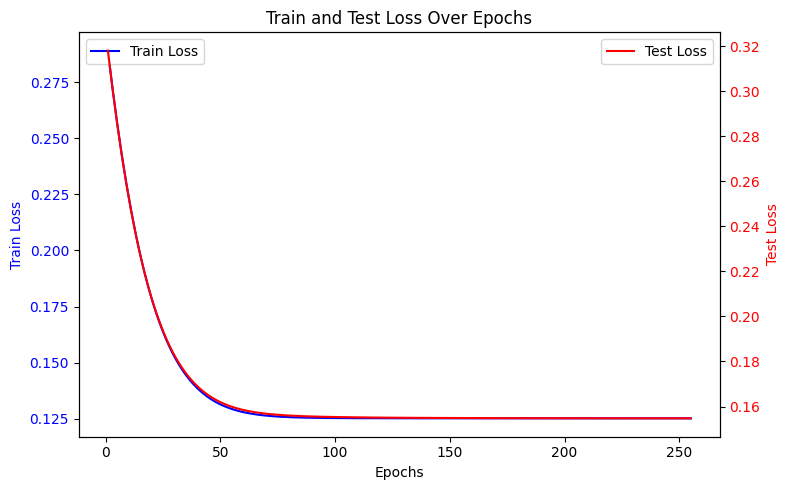

In [ ]:
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

max_loss = 999999999
patience_counter = 0

train_loss_list, test_loss_list = train_deep_learning_model(model, train_dl, test_dl, criterion, optimizer, num_epochs, patience, save_path)
plot_loss_curve(train_loss_list, test_loss_list)

### Result

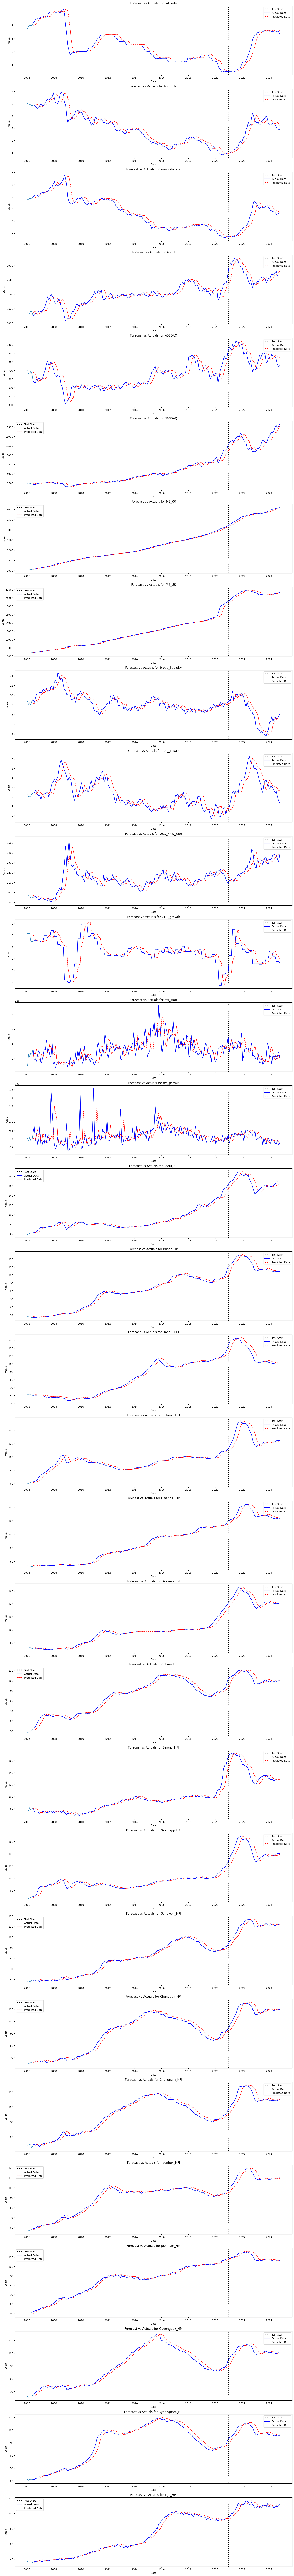

In [7]:
# Load model and Evaluate
model.load_state_dict(torch.load(save_path))  # 최적 모델 로드
model.eval()

train_dl  = DataLoader(train_ds,  batch_size = len(train_df), shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

train_outputs, train_targets = evaluate_model(model, train_dl)
test_outputs, test_targets   = evaluate_model(model, test_dl)

train_predicted = train_outputs[:, -1, :].cpu().numpy()
train_actual    = train_targets[:, -1, :].cpu().numpy()
train_dates = train_date_list[:, -1] 

test_predicted  = test_outputs[:, -1, :].cpu().numpy()
test_actual     = test_targets[:, -1, :].cpu().numpy()
test_dates = test_date_list[:, -1] 

plot_draw_all_results(columns_to_use, mean_, std_, target_df.columns,
                      DIR_PATH+f"result_{version}.csv", df, train_dates, train_actual, train_predicted,
                      test_dates, test_actual, test_predicted)